In [1]:
import torch
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('../')
from dataloader import get_train_and_validation_dataloader

## Notebook used in the construction of custom novel denoising model

In [2]:
# Creating of Patch Extractor.
train_dataloader, validation_dataloader = get_train_and_validation_dataloader(root_dataset_dir="../../../../../../Dataset/LowDoseCTGrandChallenge/Training_Image_Data", shuffle=False)

number of image paths :  15154
number of image paths :  1471
Train and validation data image len : 15154, 1471


In [3]:
# Test to check the number of patches per image.
# The format is : number_of_images_in_batch, patch_count, patch_height, patch_width, num_channels
data = next(iter(train_dataloader))
print('len of images in batch : ', len(data))
print('shape of each image in batch : ', data[0].shape)


print(data[0].shape, data[1].shape)

len of images in batch :  2
shape of each image in batch :  torch.Size([1, 512, 512, 1])
torch.Size([1, 512, 512, 1]) torch.Size([1, 512, 512, 1])


In [4]:
import pywt, ptwt
low_freq, _high_freq = ptwt.wavedec2(torch.squeeze(data[0]), pywt.Wavelet('haar'), level=1, mode="constant") 
print(low_freq.shape)
print(_high_freq[0].shape)
ptwt.waverec2((low_freq, _high_freq), pywt.Wavelet('haar')).shape

torch.Size([1, 256, 256])
torch.Size([1, 256, 256])


torch.Size([1, 512, 512])

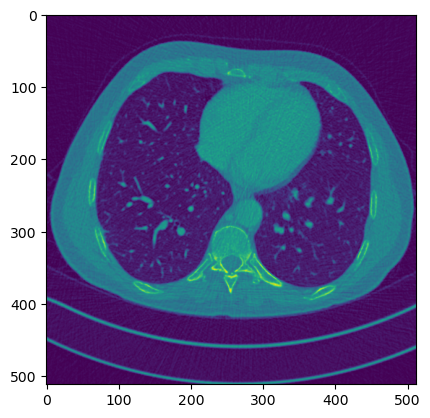

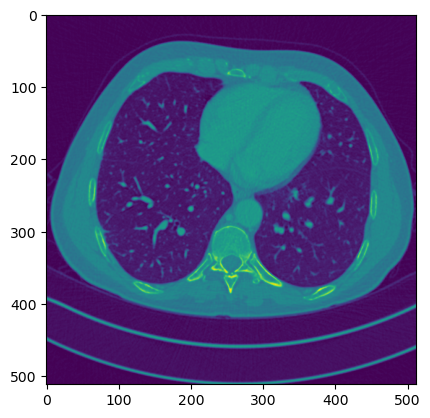

In [5]:
    
plt.imshow(np.squeeze(data[0]))
plt.show()
plt.imshow(np.squeeze(data[1]))

# Input Projection Layer

### Used to increase the number of channels in the image

In [6]:
class InputProjectionLayer(torch.nn.Module):
    def __init__(self, num_channels, kernel_size=(3,3)):
        super(InputProjectionLayer, self).__init__()
        
        self.conv = torch.nn.Conv2d(1, num_channels, kernel_size, padding='same')
        
    def forward(self, images):
        print(images.shape)
        images = torch.transpose(images, 3, 1)
        return self.conv(images)
    

ip = InputProjectionLayer(num_channels=56)(data[0])
ip.shape

torch.Size([1, 512, 512, 1])


torch.Size([1, 56, 512, 512])

# Output Projection Layer

In [7]:
class OutputProjectionLayer(torch.nn.Module):
    def __init__(self, num_channels, kernel_size=(3,3)):
        super(OutputProjectionLayer, self).__init__()
        
        self.conv2d_transpose = torch.nn.ConvTranspose2d(num_channels, 1, kernel_size, padding=1)
        
    def forward(self, images):
        images = self.conv2d_transpose(images)
        images = torch.transpose(images, 3,  1)
        return images
    
op = OutputProjectionLayer(num_channels=56)(ip)
op.shape

torch.Size([1, 512, 512, 1])

# Convolution Block (i.e ConvNext block)

In [8]:
class DepthWiseSeparableConv2d(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, bias=False):
        super(DepthWiseSeparableConv2d, self).__init__()
        self.depthwise = torch.nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, 
                               groups=in_channels, bias=bias, padding='same')
        self.pointwise = torch.nn.Conv2d(in_channels, out_channels, 
                               kernel_size=1, bias=bias)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

class ConvBlock(torch.nn.Module):
    def __init__(self, num_channels, width, height):
        super(ConvBlock, self).__init__()
        
        self.zero_padding = torch.nn.ZeroPad2d(padding=3)
        self.dwconv = DepthWiseSeparableConv2d(num_channels, num_channels, 7)
        self.layer_norm = torch.nn.LayerNorm([1, num_channels, width + 6, height + 6], elementwise_affine=False)
        self.linear_1 = torch.nn.Conv2d(num_channels, num_channels * 4, kernel_size=7)
        self.gelu = torch.nn.GELU()
        self.linear_2 = torch.nn.Conv2d(num_channels * 4, num_channels, kernel_size=1) 
        
    def forward(self, images):
        residual = images
        
        images = self.zero_padding(images)
        images = self.dwconv(images)
        images = self.layer_norm(images)
        images = self.linear_1(images)
        images = self.gelu(images)
        images = self.linear_2(images)
        return images + residual 

            
cb = ConvBlock(56, 512, 512)(ip)
cb.shape

torch.Size([1, 56, 512, 512])

# Y block

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class YBlock(nn.Module):
    def __init__(self, attention_scaling_factor, num_channels, width, height):
        super(YBlock, self).__init__()

        self.dk = attention_scaling_factor
        self.c = num_channels

        # Defining the layers for path B (self-attention, conv)

        # (Q, K, V) are used for attention.
        # This is clear from the paper which mentions:
        # The (original) self-attentive mechanism first generates the corresponding query e
        # (q), Key (K) and Value (V)
        # The output of K and Q linear are: HW/k^2 x C
        # Note that the vectors (output of self.k/q/v_linear) are PER channel (C).
        self.k_linear = nn.Linear(self.c, self.c, bias=True)
        self.q_linear = nn.Linear(self.c, self.c, bias=True)
        self.v_linear = nn.Linear(self.c, self.c, bias=True)
        self.self_attention_linear = nn.Conv2d(num_channels, num_channels, kernel_size=1)

        # Defining the layers for the stage where the input is the output of path A and path B
        self.norm = nn.LayerNorm([num_channels, height, width], elementwise_affine=False)  
        self.linear_1 = nn.Conv2d(num_channels, num_channels * 4, kernel_size=1)
        self.gelu = nn.GELU()
        self.linear_2 = nn.Conv2d(num_channels * 4, num_channels, kernel_size=1)

    def forward(self, images):
        images_dup = images

        # Attention module computation.
        # Q, K, V all pass through linear layers.

        # We are converting that into (num_images, height' * width', channel)
        flattened_images = images.view(images.size(0), -1, self.c)

        q = self.q_linear(flattened_images)
        # For the computation of the attention map, we need the shape of q to be num_images, num_channels, HW.
        # But now, it is num_images, HW, num_channels. The last 2 dimensions must be reversed.
        q = q.permute(0, 2, 1)
        print('shape of q: ', q.shape)

        k = self.k_linear(flattened_images)
        print('k shape: ', k.shape)

        flattened_images = images.view(images.size(0), -1, self.c)
        print('shape of flattened images: ', flattened_images.shape)

        v = self.v_linear(flattened_images)
        print('shape of v:', v.shape)

        # Computation of attention
        # attention = ((K'T Q) / sqrt(dk)) V
        # Ignoring num_images, the shape of Q is (num_channels)
        attention = torch.matmul(q, k)
        print('q * k shape: ', attention.shape)

        # As per the paper, after performing softmax, we obtain an attention score matrix with dimension C x C.
        # The scaling factor mentioned in the paper (i.e 1/sqrt(dk)) is based on network depth.
        attention = F.softmax(attention / torch.sqrt(torch.tensor(self.dk, dtype=torch.float32)), dim=-1)

        # Now, the final attention map is obtained by multiplying v and attention.
        attention = torch.matmul(v, attention)

        print('final attention shape: ', attention.shape)

        # Now, attention is reshaped into the same dimensions as the input image.
        sa_output = attention.view(-1, images_dup.size(1), images_dup.size(2), images_dup.size(3))

        output = images_dup + sa_output 
        print(output.shape)

        return output 

hformer_block = YBlock(attention_scaling_factor=1, num_channels=56, width=512, height=512)(cb)
hformer_block.shape

shape of q:  torch.Size([1, 56, 262144])
k shape:  torch.Size([1, 262144, 56])
shape of flattened images:  torch.Size([1, 262144, 56])
shape of v: torch.Size([1, 262144, 56])
q * k shape:  torch.Size([1, 56, 56])
final attention shape:  torch.Size([1, 262144, 56])
torch.Size([1, 56, 512, 512])


torch.Size([1, 56, 512, 512])

# Y model

In [34]:
import ptwt
import pywt 

class YModel(torch.nn.Module):
    def __init__(self, num_channels, width=256, height=256):
        super(YModel, self).__init__()
        
        self.upsampling_layer_1 = torch.nn.ConvTranspose2d(1, 1, kernel_size=(2, 2), stride=2)
        self.downsampling_layer_1 = torch.nn.Conv2d(num_channels, num_channels, kernel_size=(2,2), stride=2)

        num_channels_low_freq, num_channels_high_freq = num_channels, num_channels

        self.ip = InputProjectionLayer(num_channels=num_channels_low_freq)
        self.op = OutputProjectionLayer(num_channels=num_channels_low_freq)

        # Low frequency network blocks.
        self.low_freq_conv_block_1 = ConvBlock(num_channels=num_channels_low_freq, width=width, height=height)
        self.low_freq_conv_block_2 = ConvBlock(num_channels=num_channels_low_freq, width=width, height=height) 
        
        self.low_freq_conv_block_3 = ConvBlock(num_channels=num_channels_low_freq, width=width, height=height)
        self.low_freq_conv_block_4 = ConvBlock(num_channels=num_channels_low_freq, width=width, height=height) 

        self.yblock_low_freq = YBlock(attention_scaling_factor = 5, num_channels=num_channels_low_freq, width=width, height=height )

        # High frequency network blocks.
        self.high_freq_conv_block_1 = ConvBlock(num_channels=num_channels_high_freq, width=width, height=height)
        self.high_freq_conv_block_2 = ConvBlock(num_channels=num_channels_high_freq, width=width, height=height) 

        self.high_freq_conv_block_3 = ConvBlock(num_channels=num_channels_low_freq, width=width, height=height)
        self.high_freq_conv_block_4 = ConvBlock(num_channels=num_channels_low_freq, width=width, height=height) 

        self.yblock_high_freq =YBlock(attention_scaling_factor = 2, num_channels=num_channels_high_freq, width=width, height=height)

    def forward(self, images):
        print(images.shape)
        # dwt to get high and low freq components separately.
        # Also note that it is expected that images are passed in one at a time.
        low_freq, _high_freq = ptwt.wavedec2(torch.squeeze(images), pywt.Wavelet('haar'), level=1, mode="constant") 

        print('lf ', low_freq.shape, 'hf ', len(_high_freq), _high_freq[0].shape)

        low_freq = torch.unsqueeze(low_freq, -1)

        low_freq = self.ip(low_freq)

        # Low freq pass.
        lf_conv_block_1 = self.low_freq_conv_block_1(low_freq)
        print('lf conv block 1 ', lf_conv_block_1.shape)
        lf_conv_block_2 = self.low_freq_conv_block_2(lf_conv_block_1) + lf_conv_block_1
        lf_xblock_1 = self.yblock_low_freq(lf_conv_block_1)
        lf_conv_block_3 = self.low_freq_conv_block_3(lf_xblock_1) + lf_conv_block_2
        lf_conv_block_4 = self.low_freq_conv_block_4(lf_conv_block_3) + lf_conv_block_1

        low_freq_output = self.op(lf_conv_block_4)
        print('low freq shape : ', low_freq_output.shape)

        # High freq pass.
        high_freq_output = [None]* 3
        i = 0
        for high_freq in _high_freq:
            high_freq = self.ip(torch.unsqueeze(high_freq, -1))
            hf_conv_block_1 = self.high_freq_conv_block_1(high_freq)
            hf_conv_block_2 = self.high_freq_conv_block_2(hf_conv_block_1) + hf_conv_block_1

            hf_xblock_1 = self.yblock_high_freq(hf_conv_block_2)

            hf_conv_block_3 = self.high_freq_conv_block_3(hf_xblock_1) + hf_conv_block_2
            hf_conv_block_4 = self.high_freq_conv_block_4(hf_conv_block_3) + hf_conv_block_1

            print(i)
            high_freq_output[i] = self.op(hf_conv_block_4)
            i = i + 1

        lf = torch.unsqueeze(torch.squeeze(low_freq), 0)
        hf_1 = torch.unsqueeze(torch.squeeze(high_freq_output[0]), 0)
        hf_2 = torch.unsqueeze(torch.squeeze(high_freq_output[1]), 0)
        hf_3 = torch.unsqueeze(torch.squeeze(high_freq_output[2]), 0)


        op = ptwt.waverec2((lf, (hf_1, hf_2, hf_3)), pywt.Wavelet('haar'))
        print('op shape :: ', op.shape)
        op = torch.transpose(op, 1, 2)
        print('waverec2 shape : ', op.shape)

        return torch.unsqueeze(op, -1) + images



xm = YModel(num_channels=1).to('cuda')
xm = xm(data[0].to('cuda'))
xm.shape

torch.Size([1, 512, 512, 1])
lf  torch.Size([1, 256, 256]) hf  3 torch.Size([1, 256, 256])
torch.Size([1, 256, 256, 1])
lf conv block 1  torch.Size([1, 1, 256, 256])
shape of q:  torch.Size([1, 1, 65536])
k shape:  torch.Size([1, 65536, 1])
shape of flattened images:  torch.Size([1, 65536, 1])
shape of v: torch.Size([1, 65536, 1])
q * k shape:  torch.Size([1, 1, 1])
final attention shape:  torch.Size([1, 65536, 1])
torch.Size([1, 1, 256, 256])
low freq shape :  torch.Size([1, 256, 256, 1])
torch.Size([1, 256, 256, 1])
shape of q:  torch.Size([1, 1, 65536])
k shape:  torch.Size([1, 65536, 1])
shape of flattened images:  torch.Size([1, 65536, 1])
shape of v: torch.Size([1, 65536, 1])
q * k shape:  torch.Size([1, 1, 1])
final attention shape:  torch.Size([1, 65536, 1])
torch.Size([1, 1, 256, 256])
0
torch.Size([1, 256, 256, 1])
shape of q:  torch.Size([1, 1, 65536])
k shape:  torch.Size([1, 65536, 1])
shape of flattened images:  torch.Size([1, 65536, 1])
shape of v: torch.Size([1, 65536, 

torch.Size([1, 512, 512, 1])

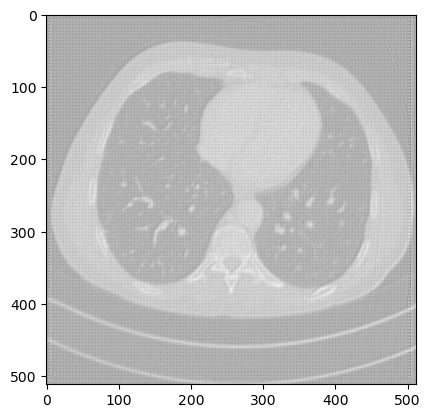

In [35]:
plt.imshow(np.squeeze(xm.detach().cpu()), cmap='gray')

In [ ]:
from torchinfo import summary
summary(XModel(num_channels=56), (512, 512,  1)) 

torch.Size([1, 256, 256, 1])
torch.Size([1, 256, 256, 1])
lf conv block 1  torch.Size([1, 56, 256, 256])
shape of q:  torch.Size([1, 56, 65536])
k shape:  torch.Size([1, 65536, 56])
shape of flattened images:  torch.Size([1, 65536, 56])
shape of v: torch.Size([1, 65536, 56])
q * k shape:  torch.Size([1, 56, 56])
final attention shape:  torch.Size([1, 65536, 56])
torch.Size([1, 56, 256, 256])
low freq shape :  torch.Size([1, 256, 256, 1])
shape of q:  torch.Size([1, 56, 65536])
k shape:  torch.Size([1, 65536, 56])
shape of flattened images:  torch.Size([1, 65536, 56])
shape of v: torch.Size([1, 65536, 56])
q * k shape:  torch.Size([1, 56, 56])
final attention shape:  torch.Size([1, 65536, 56])
torch.Size([1, 56, 256, 256])
op shape :  torch.Size([1, 256, 256, 1])


Layer (type:depth-idx)                        Output Shape              Param #
XModel                                        [1, 512, 512, 1]          12,600
├─InputProjectionLayer: 1-1                   [1, 56, 256, 256]         --
│    └─Conv2d: 2-1                            [1, 56, 256, 256]         560
├─InputProjectionLayer: 1-2                   [1, 56, 256, 256]         (recursive)
│    └─Conv2d: 2-2                            [1, 56, 256, 256]         (recursive)
├─ConvBlock: 1-3                              [1, 56, 256, 256]         --
│    └─ZeroPad2d: 2-3                         [1, 56, 262, 262]         --
│    └─DepthWiseSeparableConv2d: 2-4          [1, 56, 262, 262]         --
│    │    └─Conv2d: 3-1                       [1, 56, 262, 262]         2,744
│    │    └─Conv2d: 3-2                       [1, 56, 262, 262]         3,136
│    └─LayerNorm: 2-5                         [1, 56, 262, 262]         --
│    └─Conv2d: 2-6                            [1, 224, 256, 256]  

In [ ]:
# Testing of training (1 epoch)